In [1]:
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('../data/US_Accidents_March23_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127862 entries, 0 to 127861
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               127862 non-null  int64  
 1   Start_Lat              127862 non-null  float64
 2   Start_Lng              127862 non-null  float64
 3   Street                 127862 non-null  object 
 4   City                   127862 non-null  object 
 5   County                 127862 non-null  object 
 6   State                  127862 non-null  object 
 7   Zipcode                127862 non-null  object 
 8   Timezone               127862 non-null  object 
 9   Airport_Code           127862 non-null  object 
 10  Temperature(F)         127862 non-null  float64
 11  Humidity(%)            127862 non-null  float64
 12  Pressure(in)           127862 non-null  float64
 13  Visibility(mi)         127862 non-null  float64
 14  Wind_Direction         127862 non-nu

In [3]:
df = df.drop(['Zipcode', 'Airport_Code','Street'], axis=1)

In [4]:
df.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'City', 'County', 'State',
       'Timezone', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight', 'Clear', 'Cloud', 'Rain',
       'Heavy_Rain', 'Snow', 'Heavy_Snow', 'Fog', 'Year', 'Month', 'Day',
       'Hour', 'Minute', 'Precipitation_NA'],
      dtype='object')

In [5]:
df_dummy = pd.get_dummies(df, drop_first=True)

target='Severity'

y = df_dummy[target]
X = df_dummy.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((102289, 8126), (102289,)), ((25573, 8126), (25573,)))

# Model Training

## Helper Functions

In [6]:
def get_accuracy(prediction_labels, true_labels):    
    num_correct = np.sum(prediction_labels == true_labels)
    accuracy = num_correct / len(true_labels)
    return accuracy

## Random Forest

In [14]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_pred=rf.predict(X_test)

In [15]:
rf_acc=get_accuracy(rf_pred, y_test)
print("[Random Forest] accuracy_score: {:.3f}.".format(rf_acc))

[Random Forest] accuracy_score: 0.814.


In [17]:
joblib.dump(rf, '../models/random_forest_model.pkl')

['../models/random_forest_model.pkl']

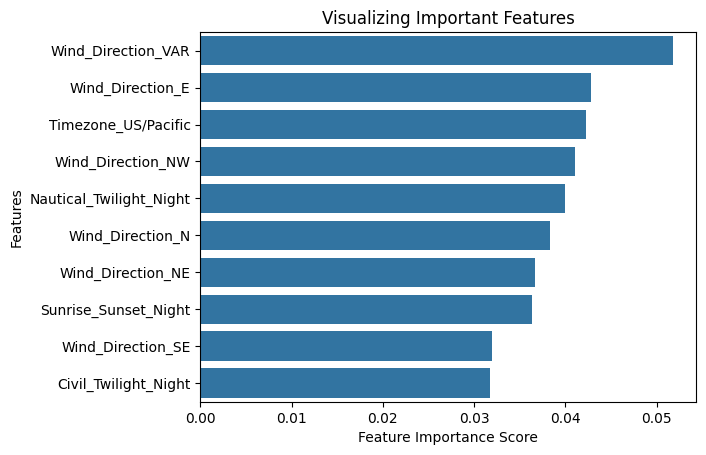

In [89]:
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)

k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## K-Nearest Neighbors

In [100]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [101]:
acc_knn = get_accuracy(y_pred_knn, y_test)
print("[KNN algorithm] accuracy_score: {:.3f}".format(acc_knn))

[KNN algorithm] accuracy_score: 0.772


In [ ]:
joblib.dump(knn, '../models/knn_model.pkl')

# Decision Tree

In [11]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth=0):
        num_labels = len(np.unique(y))

        # Base cases
        if depth == self.max_depth or num_labels == 1:
            return np.argmax(np.bincount(y))

        best_feature, best_threshold = self._find_best_split(X, y)

        # Split the data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_tree, 'right': right_tree}

    def _find_best_split(self, X, y):
        best_gain = 0
        best_feature = None
        best_threshold = None

        _, num_features = X.shape

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                gain = self._calculate_gain(X, y, feature, threshold)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gain(self, X, y, feature, threshold):
        parent_entropy = self._calculate_entropy(y)

        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold

        left_entropy = self._calculate_entropy(y[left_indices])
        right_entropy = self._calculate_entropy(y[right_indices])

        num_left = len(y[left_indices])
        num_right = len(y[right_indices])
        total_samples = num_left + num_right

        gain = parent_entropy - ((num_left / total_samples) * left_entropy) - ((num_right / total_samples) * right_entropy)

        return gain

    def _calculate_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))

        return entropy

    def _traverse_tree(self, x, tree):
        if isinstance(tree, dict):
            feature = tree['feature']
            threshold = tree['threshold']

            if x[feature] <= threshold:
                return self._traverse_tree(x, tree['left'])
            else:
                return self._traverse_tree(x, tree['right'])
        else:
            return tree

In [12]:
dt = DecisionTree(max_depth=4)
dt.fit(X_train.values, y_train.values)
y_pred_dt = dt.predict(X_test.values)

acc_dt = get_accuracy(y_pred_dt, y_test.values)
print("[Decision Tree algorithm] accuracy_score: {:.3f}".format(acc_dt))

[Decision Tree algorithm] accuracy_score: 0.794


In [13]:
joblib.dump(dt, '../models/decision_tree_model.pkl')

['../models/decision_tree_model.pkl']